In [1]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import math

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import layers

print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 

# CLEAN UP MEMORY
gc.collect()

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


22

In [2]:
#READ DATA FROM FILE
dataset=pd.read_csv("C:/ProgramData/ETH/TrainingData/training.csv", sep=',',header=0)
#PRINT DATA
print(dataset)

             close        date        high         low        open  \
0       515.609375  1527552000  515.609375  512.633685  512.633685   
1       514.018489  1527552300  514.832422  513.291775  513.291775   
2       514.758432  1527552600  514.758432  514.290853  514.546926   
3       513.794384  1527552900  515.055799  513.794384  514.042601   
4       515.085181  1527553200  516.370237  515.085181  515.457029   
...            ...         ...         ...         ...         ...   
218272  391.110000  1603790400  392.146190  391.100000  392.146160   
218273  390.632145  1603790700  391.611541  390.539082  391.409900   
218274  391.092113  1603791000  391.092113  390.840042  390.840042   
218275  390.674457  1603791300  390.908181  390.094629  390.908181   
218276  390.986180  1603791600  390.986180  390.298756  390.646077   

        quoteVolume        volume  weightedAverage  
0         93.446187  48034.930402       514.038418  
1          1.658992    854.079129       514.818062  


In [3]:
#CONDUCT PEARSON CORRELATION
correlation_matrix = dataset.corr()
print(correlation_matrix)

                    close      date      high       low      open  \
close            1.000000 -0.037330  0.999990  0.999989  0.999983   
date            -0.037330  1.000000 -0.037224 -0.037568 -0.037436   
high             0.999990 -0.037224  1.000000  0.999978  0.999990   
low              0.999989 -0.037568  0.999978  1.000000  0.999987   
open             0.999983 -0.037436  0.999990  0.999987  1.000000   
quoteVolume     -0.055925  0.196716 -0.054221 -0.057756 -0.055673   
volume           0.085438  0.214307  0.087221  0.083457  0.085706   
weightedAverage  0.999995 -0.037392  0.999993  0.999993  0.999992   

                 quoteVolume    volume  weightedAverage  
close              -0.055925  0.085438         0.999995  
date                0.196716  0.214307        -0.037392  
high               -0.054221  0.087221         0.999993  
low                -0.057756  0.083457         0.999993  
open               -0.055673  0.085706         0.999992  
quoteVolume         1.000000  

<AxesSubplot:>

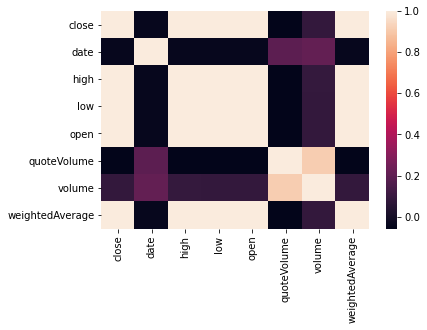

In [4]:
# plot the heatmap
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)

In [5]:
#SELECT FEATURES AND TARGET
data = dataset[["high","low","open","weightedAverage", "close"]]
print(data)

              high         low        open  weightedAverage       close
0       515.609375  512.633685  512.633685       514.038418  515.609375
1       514.832422  513.291775  513.291775       514.818062  514.018489
2       514.758432  514.290853  514.546926       514.605286  514.758432
3       515.055799  513.794384  514.042601       514.191683  513.794384
4       516.370237  515.085181  515.457029       515.591183  515.085181
...            ...         ...         ...              ...         ...
218272  392.146190  391.100000  392.146160       391.706521  391.110000
218273  391.611541  390.539082  391.409900       391.038784  390.632145
218274  391.092113  390.840042  390.840042       390.885476  391.092113
218275  390.908181  390.094629  390.908181       390.634386  390.674457
218276  390.986180  390.298756  390.646077       390.909552  390.986180

[218277 rows x 5 columns]


In [6]:
#SCALE DATA 
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [7]:
#DEFINE MODEL CREATION METHOD. ENABLES EASY HYPER PARAM TUNING
def build_model(inputs, neurons, activ_func, dropout, loss, optimizer):
    """
    inputs: input data as numpy array
    output_size: number of predictions per input sample
    neurons: number of neurons/ units in the LSTM layer
    active_func: Activation function to be used in LSTM layers and Dense layer
    dropout: dropout ration, default is 0.25
    loss: loss function for calculating the gradient
    optimizer: type of optimizer to backpropagate the gradient
    
    This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
    and finally a dense layer to produce the output using keras' sequential model.
    Return: Keras sequential model and model summary
    """
    
    model = models.Sequential()
    model.add(layers.LSTM(neurons, return_sequences=False, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(units=inputs.shape[2]))
    #model.add(layers.Dense(units=1))
    model.add(layers.Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
    model.summary()
    return model

In [8]:
def split_data(training_split, data):
    # split into train and test sets
    train_size = int(len(data) * training_split)
    test_size = len(data) - train_size
    train, test = data[0:train_size,:], data[train_size:len(data),:]
    return (train, test)

In [9]:
def split_sequences_multivariate_output(sequences, look_back):
    x, y = list(), list()
    for i in range(len(sequences)):
        # end index of lookback window
        end_ix = i + look_back
        # exit if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern. input is lookback window of data, output is next step of data
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        x.append(seq_x)
        y.append(seq_y)
            
    return np.array(x), np.array(y)

In [16]:
#INIT HYPER PARAMS
neurons = 512
activation_function = 'tanh'
loss = 'mse'
optimizer="adam"
dropout = 0.2
batch_size = 12
#epochs = 100
epochs = 1
training_split = 0.7
look_back = 6

In [11]:
#SPLIT DATA FOR TRAINING
train_data, test_data = split_data(training_split, data)

In [12]:
#SHAPE DATA FOR LSTM INPUT
x_train, y_train = split_sequences_multivariate_output(train_data, look_back)
x_test, y_test = split_sequences_multivariate_output(test_data, look_back)

#PRINT DATA SHAPE
print('training features shape == {}.'.format(x_train.shape))
print('training targets shape == {}.'.format(y_train.shape))
print('testing features shape == {}.'.format(x_test.shape))
print('testing features shape == {}.'.format(y_test.shape))

print("X_TRAIN")
print(x_train)
print("Y_TRAIN")
print(y_train)

training features shape == (152787, 6, 5).
training targets shape == (152787, 5).
testing features shape == (65478, 6, 5).
testing features shape == (65478, 5).
X_TRAIN
[[[0.79381908 0.79306201 0.78975707 0.79399787 0.7947809 ]
  [0.79239617 0.79427395 0.79096397 0.79543074 0.7918645 ]
  [0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145367]
  [0.79521252 0.79757672 0.79493492 0.79685162 0.79381995]
  [0.79286119 0.79658428 0.79326466 0.79522572 0.79382207]]

 [[0.79239617 0.79427395 0.79096397 0.79543074 0.7918645 ]
  [0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145367]
  [0.79521252 0.79757672 0.79493492 0.79685162 0.79381995]
  [0.79286119 0.79658428 0.79326466 0.79522572 0.79382207]
  [0.79286119 0.79757885 0.79425509 0.79592379 0.79382207]]

 [[0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145367]
 

In [13]:
y_train =  np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
y_test =  np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [14]:
#PRINT DATA SHAPE
print('training features shape == {}.'.format(x_train.shape))
print('training targets shape == {}.'.format(y_train.shape))
print('testing features shape == {}.'.format(x_test.shape))
print('testing features shape == {}.'.format(y_test.shape))

print("X_TRAIN")
print(x_train)
print("Y_TRAIN")
print(y_train)

training features shape == (152787, 6, 5).
training targets shape == (152787, 1, 5).
testing features shape == (65478, 6, 5).
testing features shape == (65478, 1, 5).
X_TRAIN
[[[0.79381908 0.79306201 0.78975707 0.79399787 0.7947809 ]
  [0.79239617 0.79427395 0.79096397 0.79543074 0.7918645 ]
  [0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145367]
  [0.79521252 0.79757672 0.79493492 0.79685162 0.79381995]
  [0.79286119 0.79658428 0.79326466 0.79522572 0.79382207]]

 [[0.79239617 0.79427395 0.79096397 0.79543074 0.7918645 ]
  [0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145367]
  [0.79521252 0.79757672 0.79493492 0.79685162 0.79381995]
  [0.79286119 0.79658428 0.79326466 0.79522572 0.79382207]
  [0.79286119 0.79757885 0.79425509 0.79592379 0.79382207]]

 [[0.79226066 0.79611387 0.79326584 0.79503969 0.79322096]
  [0.79280526 0.79519957 0.79234094 0.79427955 0.79145

In [17]:
# CLEAN UP MEMORY
gc.collect()
# random seed for reproducibility
np.random.seed(404)
# initialise model architecture
model = build_model(x_train, neurons=neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer)
# train model on data
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test), shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1060864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
Total params: 1,063,429
Trainable params: 1,063,429
Non-trainable params: 0
_________________________________________________________________
12733/12733 [==============================] - 57s 4ms/step - loss: 0.0014 - mae: 0.0136 - val_loss: 0.0281 - val_mae: 0.1308


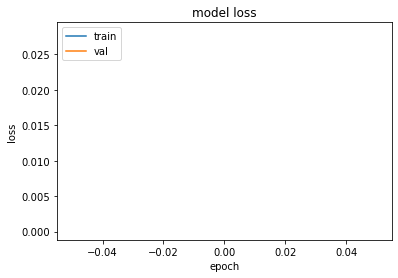

In [18]:
#PLOT LOSS
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

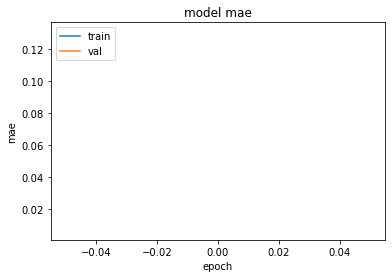

In [19]:
#PLOT LOSS
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
#PERFORM PREDICTIONS
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
print(train_predict.shape)
print(test_predict.shape)

(152787, 5)
(65478, 5)


In [21]:
test_predict_shaped = scaler.inverse_transform(np.array(test_predict))
train_predict_shaped = scaler.inverse_transform(np.array(train_predict))
test_predict_shaped = test_predict_shaped[:,4:5]
train_predict_shaped = train_predict_shaped[:,4:5]
print(test_predict_shaped.shape)
print(train_predict_shaped.shape)

(65478, 1)
(152787, 1)


In [22]:
train_mse = mean_squared_error(y_train[:,0,4], train_predict[:,4])
test_mse = mean_squared_error(y_test[:,0,4], test_predict[:,4])
# calculate mean squared error
print('Train Score: %.2f RMSE' % (train_mse))
print('Test Score: %.2f RMSE' % (test_mse))

# calculate root mean squared error
print('Train Score: %.2f RMSE' % (math.sqrt(train_mse)))
print('Test Score: %.2f RMSE' % (math.sqrt(test_mse)))

# calculate root mean abs error
print('Train Score: %.2f MAE' % (mean_absolute_error(y_train[:,0,4], train_predict[:,4])))
print('Test Score: %.2f MAE' % (mean_absolute_error(y_test[:,0,4], test_predict[:,4])))

# calculate root mean squared error
print('Train Score: %.2f MAPE' % (mean_absolute_percentage_error(y_train[:,0,4], train_predict[:,4])))
print('Test Score: %.2f MAPE' % (mean_absolute_percentage_error(y_test[:,0,4], test_predict[:,4])))

Train Score: 0.03 RMSE
Test Score: 0.03 RMSE
Train Score: 0.18 RMSE
Test Score: 0.17 RMSE
Train Score: 0.13 MAE
Test Score: 0.13 MAE
Train Score: 6114968280.37 MAPE
Test Score: 0.43 MAPE


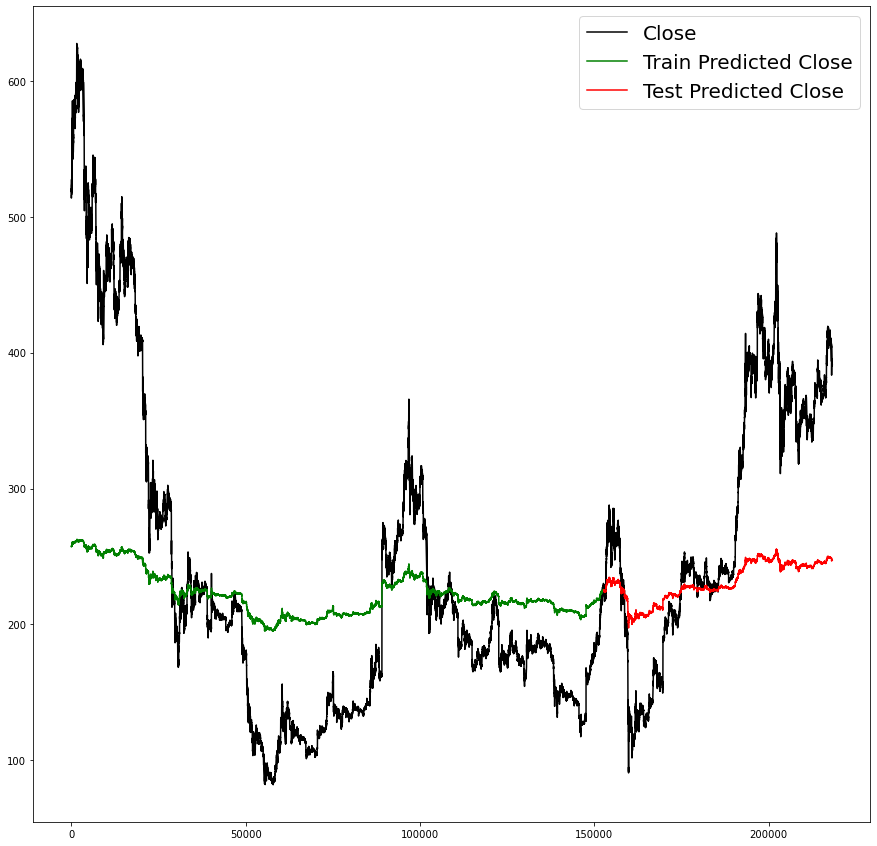

In [24]:

baseData = scaler.inverse_transform(data)[:, 4:5]
# initialize to length of base data
trainPredictPlot = np.empty_like(baseData)
# set all elements to nan
trainPredictPlot[:, :] = np.nan
# shift train predictions by window length for plotting
trainPredictPlot[look_back:len(train_predict_shaped)+look_back, :] = train_predict_shaped
# initialize to length of base data
testPredictPlot = np.empty_like(baseData)
#set all elements to nan
testPredictPlot[:, :] = np.nan
#shift by length of training predictions plus 
testPredictPlot[len(train_predict_shaped)+(look_back*2)+1:len(baseData)-1, :] = test_predict_shaped[0:65476, :]
# plot baseline and predictions
plt.figure(figsize=(15,15))
plt.plot(baseData, '-', color='k', label='Close')
plt.plot(trainPredictPlot, '-', color='g', label='Train Predicted Close')
plt.plot(testPredictPlot, '-', color='r', label='Test Predicted Close')
plt.legend(fontsize=20)

plt.show()

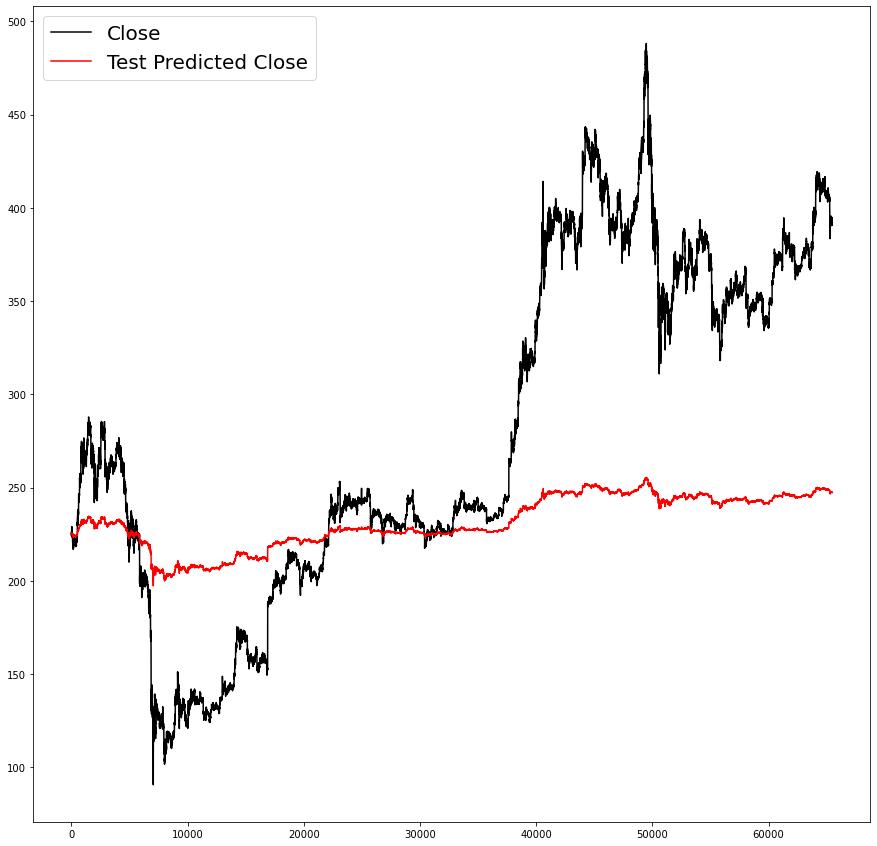

In [25]:
baseTestData = scaler.inverse_transform(test_data)[:, 4:5]
testPredictPlot2 = np.empty_like(baseTestData)
testPredictPlot2[:, :] = np.nan
testPredictPlot2[look_back:len(train_predict_shaped)+look_back, :] = test_predict_shaped
# plot baseline and predictions
plt.figure(figsize=(15,15))
plt.plot(baseTestData, '-', color='k', label='Close')
plt.plot(testPredictPlot2, '-', color='r', label='Test Predicted Close')
plt.legend(fontsize=20)

plt.show()

In [26]:
model_json = model.to_json()

with open("C:\ProgramData\ETH\Model\model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("C:\ProgramData\ETH\Model\model.h5")